In [1159]:
import pandas as pd
import numpy as np
import glob
import os
import csv
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import curve_fit
import peakutils
from lmfit.models import PseudoVoigtModel
import math
import traceback
from collections import OrderedDict
from scipy.signal import find_peaks

%matplotlib inline

In [1160]:
x_expected_633=183.27
file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250304\Ne_lamp_300_633.txt"

df = pd.read_csv(file_path, sep="\t", header=None, names=["Wavenumber", "Counts"])

# Define the Lorentzian function
def lorentzian(x, A, x0, w, B):
    return A * (w**2 / ((x - x0)**2 + w**2)) + B

# Initial guesses for [A, x0, w, B]
A_guess = max(df["Counts"]) - min(df["Counts"])  # Peak height
x0_guess = df["Wavenumber"][df["Counts"].idxmax()]  # Peak position
w_guess = (max(df["Wavenumber"]) - min(df["Wavenumber"])) / 10  # Rough FWHM estimate
B_guess = min(df["Counts"])  # Baseline offset

p0 = [A_guess, x0_guess, w_guess, B_guess]  # Initial parameter guess

# Curve fitting
popt, pcov = curve_fit(lorentzian, df["Wavenumber"], df["Counts"], p0=p0)

# Get the best-fit parameters
A_fit, x0_fit, w_fit, B_fit = popt

# Calculate maximum count value using fitted x0
max_counts_fit = lorentzian(x0_fit, *popt)
x_offset_633=x_expected_633-x0_fit
print(x_offset_633)

-0.09569878837930901


In [1161]:
x_expected_532=280.4003741
file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250305\Ne lamp_532nm_500cm-1_20x0p5s_.txt"

df = pd.read_csv(file_path, sep="\t", header=None, names=["Wavenumber", "Counts"])

# Define the Lorentzian function
def lorentzian(x, A, x0, w, B):
    return A * (w**2 / ((x - x0)**2 + w**2)) + B

# Initial guesses for [A, x0, w, B]
A_guess = max(df["Counts"]) - min(df["Counts"])  # Peak height
x0_guess = df["Wavenumber"][df["Counts"].idxmax()]  # Peak position
w_guess = (max(df["Wavenumber"]) - min(df["Wavenumber"])) / 10  # Rough FWHM estimate
B_guess = min(df["Counts"])  # Baseline offset

p0 = [A_guess, x0_guess, w_guess, B_guess]  # Initial parameter guess

# Curve fitting
popt, pcov = curve_fit(lorentzian, df["Wavenumber"], df["Counts"], p0=p0)

# Get the best-fit parameters
A_fit, x0_fit, w_fit, B_fit = popt

# Calculate maximum count value using fitted x0
max_counts_fit = lorentzian(x0_fit, *popt)

# Generate fitted curve
x_fit = np.linspace(df["Wavenumber"].min(), df["Wavenumber"].max(), 500)
y_fit = lorentzian(x_fit, *popt)

x_offset_532=x_expected_532-x0_fit
print(x_offset_532)

2.120102785895938


In [1162]:
#file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250305\STO_8-2_532nm_500cm-1_3p5mW_3x250s_YY_100xlong.txt"
file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250305\STO_4-5_532nm_500cm-1_3p5mW_4x250s_YY_100xlong.txt"
#file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250305\STO_4-5_532nm_500cm-1_2p5mW_3x200s_XX_100xlong.txt"
#file_path = r"C:\Users\Judith\Documents\BK6\Analysis\20250305\STO_8-2_532nm_500cm-1_3p5mW_3x250s_YX_100xlong.txt"
#file_path = r"C:\Users\Judith\Documents\BK6\Analysis\Dropbox\STO_633nm_300cm-1_2p5mW_5x50s_100xlong.txt" #Bulk
data = pd.read_csv(file_path, delimiter='\t', header=None, names=['Wavelength', 'Intensity'])
data['Wavelength'] = data['Wavelength'] + x_offset_532

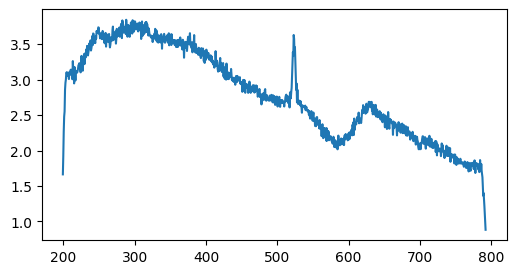

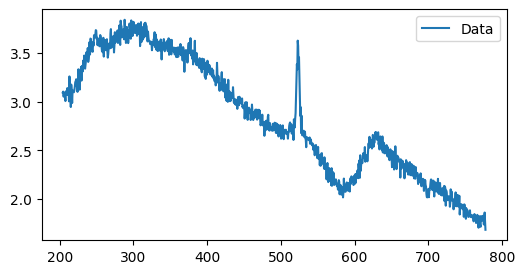

In [1163]:
plt.figure(figsize=(6, 3))
plt.plot(data['Wavelength'], data['Intensity'])
plt.show()
data = data[(data['Wavelength'] > 204) & (data['Wavelength'] < 778)]
plt.figure(figsize=(6, 3))
plt.plot(data['Wavelength'], data['Intensity'], label='Data')
plt.legend()
plt.show()

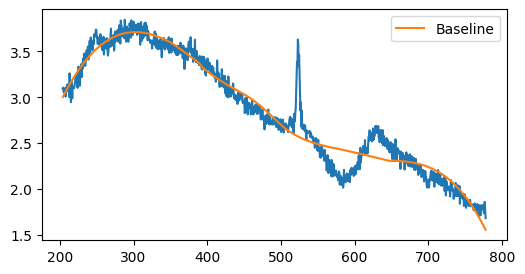

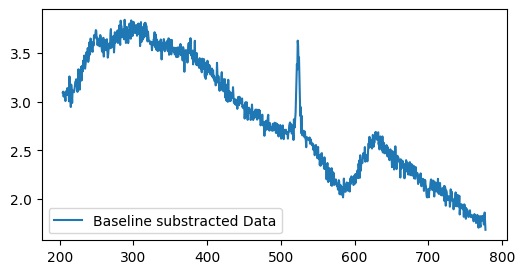

In [1164]:
# Let's try the Golay filtering

baseline_rough = scipy.signal.savgol_filter(data['Intensity'],window_length=451,polyorder=3)
plt.figure(figsize=(6, 3))
plt.plot(data['Wavelength'], data['Intensity'])
plt.plot(data['Wavelength'], baseline_rough, label='Baseline')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
correctedData = data['Intensity'] #- baseline_rough
plt.plot(data['Wavelength'], correctedData, label='Baseline substracted Data')
plt.legend()
plt.show()

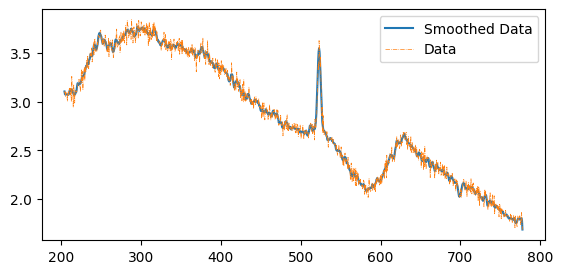

In [1165]:
# smooth the data
# a cool option is to smooth the data also using the savgol filter - for this we choose a large polynomial order and a small window

%matplotlib inline
smoothData =  scipy.signal.savgol_filter(correctedData, window_length=20, polyorder=6)
plt.figure(figsize=(6.5, 3))
plt.plot(data['Wavelength'], smoothData, label='Smoothed Data')
plt.plot(data['Wavelength'], correctedData, linewidth=0.5, linestyle='dashdot', label='Data')
plt.legend()
plt.show()




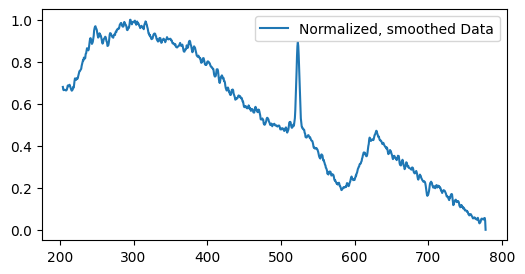

In [1166]:
# Normalize the data

normalizedData = smoothData - min(smoothData)
normalizedData = normalizedData / max(normalizedData)
plt.figure(figsize=(6, 3))
plt.plot(data['Wavelength'], normalizedData, label='Normalized, smoothed Data')
plt.legend()
plt.show()

smoothData = normalizedData

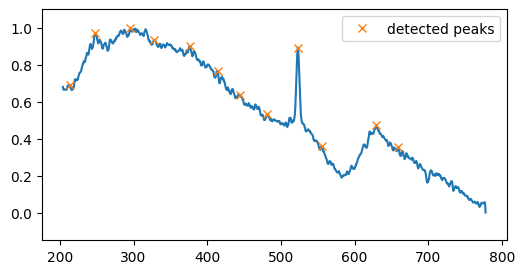

In [ ]:
#let's try to find the peaks
# x = data['Wavelength']

peaks,properties = find_peaks(smoothData, height=0.30, distance=50)   
plt.figure(figsize=(6, 3))
plt.plot(data['Wavelength'],smoothData)
plt.plot(data['Wavelength'].iloc[peaks],smoothData[peaks], "x", label="detected peaks")    ##NOTE that smoothData is a numpy array, but data['Wavelength'] is a pandas series and hence the index can be a problem
plt.legend()
plt.ylim(-0.15,1.1)
plt.show()

In [1168]:
PeakPositions = np.array(data['Wavelength'].iloc[peaks])  #converting this to a numpy array because it is easier to work with since the "indexing" doesn't matter in this case
print(PeakPositions)
PeakPositions =[248.30310279, 295.84010279, 376.23910279, 522.95210279, 555.20010279, 629.38610279, 658.79610279, 720]



[213.17310279 248.30310279 295.84010279 328.12610279 376.23910279
 413.98710279 445.07210279 481.23210279 522.95210279 555.20010279
 629.38610279 658.79610279]


In [1169]:
def multi_lorentzian(x, *params):
    """
    Sum of multiple Lorentzian peaks.
    params: [x0_1, gamma_1, A_1, x0_2, gamma_2, A_2, ..., x0_n, gamma_n, A_n]
    """
    n = len(params) // 3  # Number of peaks
    result = np.zeros_like(x)
    for i in range(n):
        x0, gamma, A = params[3*i : 3*i+3]  # Extract parameters for each peak
        result += A * gamma**2 / ((x - x0)**2 + gamma**2)       
    return result
   
def Lorentzian(x, x0, gamma, A):
    return A * gamma**2 / ((x - x0)**2 + gamma**2)
# List of peak positions (estimated manually or using `find_peaks`)
# PeakPositions = [200, 400, 600]  # Replace with your detected peak positions
x = np.array(data['Wavelength'])
y = smoothData
# Flatten the initial parameter list [x0_1, gamma_1, A_1, x0_2, gamma_2, A_2, ...]
initial_guesses = []
for peak in PeakPositions:
    initial_guesses.extend([peak, 20, max(y)])  # [x0, gamma, A] for each peak
    
# Perform curve fitting
popt, pcov = curve_fit(multi_lorentzian, x, y, p0=initial_guesses, bounds=(0, np.inf))

# Extract optimized parameters
n_peaks = len(PeakPositions)
optimized_params = np.split(popt, n_peaks)  # Split into (x0, gamma, A) per peak
#for i, (x0, gamma, A) in enumerate(optimized_params):
    #print(f"Peak {i+1}: x0 = {x0:.2f}, gamma = {gamma:.2f}, A = {A:.2f}")


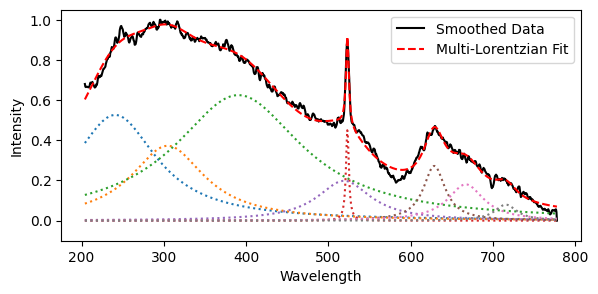

In [1170]:
plt.figure(figsize=(6.7, 3))
plt.plot(x, y, label="Smoothed Data", color='black')

plt.plot(x, multi_lorentzian(x, *popt), label="Multi-Lorentzian Fit", linestyle="--", color='red')

# Individual Lorentzian graphs
for i in range(n_peaks):
    x0, gamma, A = optimized_params[i]
    # plt.plot(x, Lorentzian(x, x0, gamma, A), linestyle=":", label=f"Peak {i+1}")
    plt.plot(x, Lorentzian(x, x0, gamma, A), linestyle=":")
    
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.legend()
plt.ylim(-0.1,1.05)
plt.show()


In [1171]:
errors = np.sqrt(np.diag(pcov))
for i in range(n_peaks):
    x0_err, gamma_err, A_err = errors[3*i:3*i+3]
    #print(f"Peak {i+1} errors: x0 = {x0_err:.2f}, gamma = {gamma_err:.2f}, A = {A_err:.2f}")

In [1172]:
import pandas as pd

# Create a DataFrame with fitting parameters and their errors
fitting_data = {
    'Peak Index': range(1, n_peaks + 1),
    'Peak Position (x0)': [params[0] for params in optimized_params],
    'x0 Error': errors[::3],  # Extracting x0 errors
    'Gamma': [params[1] for params in optimized_params],
    'Gamma Error': errors[1::3],  # Extracting gamma errors
    'A': [params[2] for params in optimized_params],
    'A Error': errors[2::3]  # Extracting A errors
}

fitting_df = pd.DataFrame(fitting_data)

# Display the DataFrame
print(fitting_df)

#save the data frame to a csv file - that one can open in excel
#fitting_df.to_csv("fitting_results_STO_8-2_532nm_500cm-1_3p5mW_3x250s_YY_100xlong.csv", index=False)



   Peak Index  Peak Position (x0)  x0 Error      Gamma  Gamma Error         A  \
0           1          240.921767  3.414104  61.330614     4.487261  0.526028   
1           2          304.594354  2.913178  54.586843     8.122586  0.372530   
2           3          390.543544  3.434770  94.624201     5.018732  0.624826   
3           4          523.082592  0.061681   2.100681     0.113511  0.451638   
4           5          519.050027  0.915549  39.881657     3.288669  0.198166   
5           6          628.678494  0.465716  16.065961     0.920041  0.272120   
6           7          666.921931  1.171803  26.698705     3.117684  0.180553   
7           8          715.599240  1.316424  16.557240     2.691715  0.079596   

    A Error  
0  0.050638  
1  0.084404  
2  0.033339  
3  0.013457  
4  0.011215  
5  0.011495  
6  0.007439  
7  0.007570  


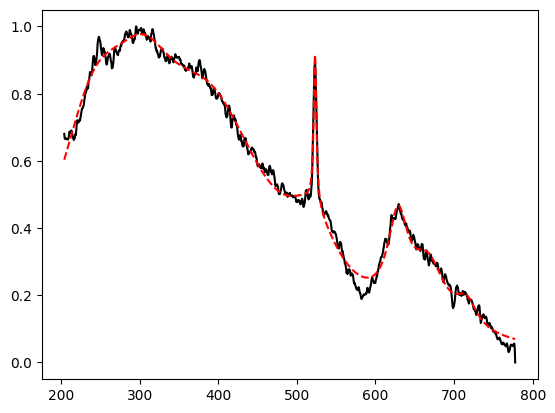

In [1173]:
# Calculate the fitted values
y_fit = multi_lorentzian(x, *popt)
plt.plot(x, y, label="Original Data", color='black')
plt.plot(x, y_fit, label="Fitted Curve", linestyle="--", color='red')


# R-squared cant be the best way...

In [1174]:

# Calculate the residuals
residuals = y - y_fit

# Calculate the total sum of squares (SST)
sst = np.sum((y - np.mean(y))**2)

# Calculate the residual sum of squares (SSR)
ssr = np.sum(residuals**2)

# Calculate R-squared
r_squared = 1 - (ssr / sst)

print(f"R-squared: {r_squared:.4f}")

R-squared: 0.9943
